In [1]:
# Selecting libraries
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")

import cvxopt as opt
from cvxopt import blas, solvers

/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# Define the assets and key initial metrics as investment amount to generate a portfolio


stocks = ['AAPL', 'MSFT', 'NVDA', 'JNJ', 'NVS','JPM','GS','AMZN','DIS','BA','CAT','XOM','CVX','RIO','BHP']
portfolio_value = 10**6                         # Initial Portfolio Value to be allocated in full
weights = [1/len(stocks)]*len(stocks)        # Weight Allocation per asset

benchmark = '^GSPC'                    # Which is your benchmark? ^GSPC is SP500 for Yfinance library

start_date = '2009-01-01'              # Start date for asset data download
live_date = '2015-01-01'                # Portfolio LIVE start date (for analytics)
end_date  ='2015-12-25'

# Warning handling
if len(weights) != len(stocks):
    print(sum((np.array(weights))))
    print('Number of Asset does not match weight allocated')
    
weight = round(sum((np.array(weights))))
if weight != 1.0:
    print(sum((np.array(weights))))
    print('Weight could not be allocated properly, make sure they sum 1.0')


In [3]:
# Download data, clean and isolate values for calculation
# If you use other data source, make sure the format is the same than stock_data.head() on next cell. Check dtypes by stock_data.info()

stock_data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
stock_data = stock_data.dropna()
stock_data = stock_data.reindex(columns=stocks)
stock_prices = stock_data[stocks].values

[*********************100%***********************]  15 of 15 completed


In [4]:
shares_df = pd.DataFrame(index=[stock_data.index[0]])

for s,w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0])

shares_df    

AAPL_shares  MSFT_shares  NVDA_shares  JNJ_shares  NVS_shares  \
2009-01-02      24233.0       4415.0      33371.0      1696.0      2640.0   

            JPM_shares  GS_shares  AMZN_shares  DIS_shares  BA_shares  \
2009-01-02      3047.0      978.0      24527.0      3236.0     1964.0   

            CAT_shares  XOM_shares  CVX_shares  RIO_shares  BHP_shares  
2009-01-02      2133.0      1409.0      1556.0      7397.0      2977.0

In [5]:
import pandas as pd
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Set the number of assets, assumed that 'df' is your DataFrame with historical prices.
df = stock_data.copy()
num_assets = len(df.columns)
stocks = df.columns

# Create an empty DataFrame to store the portfolio weights over time
optimal_weights_df = pd.DataFrame(index=df.index, columns=stocks)

# Set the window length for the rolling covariance calculation
window_length = 424 # Use 252 for approx one year of trading days

# Set the initial weights to be equal for all assets
initial_weights = np.array([1/num_assets]*num_assets)

for end_date in df.index[window_length:]:
    
    # Extract the window of data
    data_window = df.loc[:end_date].tail(window_length)
    
    # Calculate expected returns and covariance matrix for the window
    mu = expected_returns.mean_historical_return(data_window)
    S = risk_models.sample_cov(data_window)

    # Initialise and optimize the portfolio on the window of data
    ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))  # Set bounds to allow shorting
    raw_weights = ef.max_sharpe()  # Optimize for maximal Sharpe ratio
    cleaned_weights = ef.clean_weights()  # Clean the raw weights
    
    # Add the weights to our optimal_weights dataframe
    optimal_weights_df.loc[end_date] = [cleaned_weights.get(stock) for stock in stocks]

# Forward fill the weights for the days we aren't rebalancing
optimal_weights_df = optimal_weights_df.fillna(method='ffill')

# Print out the final DataFrame
print(optimal_weights_df.tail())


               AAPL  MSFT     NVDA  JNJ  NVS  JPM   GS     AMZN      DIS   BA  \
Date                                                                            
2015-12-18  0.10491   0.0  0.32121  0.0  0.0  0.0  0.0  0.44923  0.12465  0.0   
2015-12-21  0.11737   0.0  0.36757  0.0  0.0  0.0  0.0  0.46576  0.04930  0.0   
2015-12-22  0.09493   0.0  0.35881  0.0  0.0  0.0  0.0  0.44034  0.10592  0.0   
2015-12-23  0.12973   0.0  0.36068  0.0  0.0  0.0  0.0  0.45773  0.05185  0.0   
2015-12-24  0.14254   0.0  0.33963  0.0  0.0  0.0  0.0  0.46783  0.05000  0.0   

            CAT  XOM  CVX  RIO  BHP  
Date                                 
2015-12-18  0.0  0.0  0.0  0.0  0.0  
2015-12-21  0.0  0.0  0.0  0.0  0.0  
2015-12-22  0.0  0.0  0.0  0.0  0.0  
2015-12-23  0.0  0.0  0.0  0.0  0.0  
2015-12-24  0.0  0.0  0.0  0.0  0.0  


In [6]:
optimal_weights_df

AAPL  MSFT     NVDA  JNJ  NVS  JPM   GS     AMZN      DIS   BA  \
Date                                                                            
2009-01-02      NaN   NaN      NaN  NaN  NaN  NaN  NaN      NaN      NaN  NaN   
2009-01-05      NaN   NaN      NaN  NaN  NaN  NaN  NaN      NaN      NaN  NaN   
2009-01-06      NaN   NaN      NaN  NaN  NaN  NaN  NaN      NaN      NaN  NaN   
2009-01-07      NaN   NaN      NaN  NaN  NaN  NaN  NaN      NaN      NaN  NaN   
2009-01-08      NaN   NaN      NaN  NaN  NaN  NaN  NaN      NaN      NaN  NaN   
...             ...   ...      ...  ...  ...  ...  ...      ...      ...  ...   
2015-12-18  0.10491   0.0  0.32121  0.0  0.0  0.0  0.0  0.44923  0.12465  0.0   
2015-12-21  0.11737   0.0  0.36757  0.0  0.0  0.0  0.0  0.46576  0.04930  0.0   
2015-12-22  0.09493   0.0  0.35881  0.0  0.0  0.0  0.0  0.44034  0.10592  0.0   
2015-12-23  0.12973   0.0  0.36068  0.0  0.0  0.0  0.0  0.45773  0.05185  0.0   
2015-12-24  0.14254   0.0  0.33963  0.0  0.0  0.0  0.0  0.46783  0.05000  0.0   

            CAT  XOM  CVX  RIO  BHP  
Date                                 
2009-01-02  NaN  NaN  NaN  NaN  NaN  
2009-01-05  NaN  NaN  NaN  NaN  NaN  
2009-01-06  NaN  NaN  NaN  NaN  NaN  
2009-01-07  NaN  NaN  NaN  NaN  NaN  
2009-01-08  NaN  NaN  NaN  NaN  NaN  
...         ...  ...  ...  ...  ...  
2015-12-18  0.0  0.0  0.0  0.0  0.0  
2015-12-21  0.0  0.0  0.0  0.0  0.0  
2015-12-22  0.0  0.0  0.0  0.0  0.0  
2015-12-23  0.0  0.0  0.0  0.0  0.0  
2015-12-24  0.0  0.0  0.0  0.0  0.0  

[1758 rows x 15 columns]

In [7]:
start_date = df.index[window_length]
stock_data = stock_data.loc[start_date:]
shares_df = shares_df.loc[start_date:]
optimal_weights_df = optimal_weights_df.loc[start_date:]


In [9]:
shares_df

Empty DataFrame
Columns: [AAPL_shares, MSFT_shares, NVDA_shares, JNJ_shares, NVS_shares, JPM_shares, GS_shares, AMZN_shares, DIS_shares, BA_shares, CAT_shares, XOM_shares, CVX_shares, RIO_shares, BHP_shares]
Index: []

In [10]:
shares_df = pd.DataFrame(index=[stock_data.index[0]])

for s,w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0])

shares_df    

AAPL_shares  MSFT_shares  NVDA_shares  JNJ_shares  NVS_shares  \
2010-09-09       8359.0       3600.0      28552.0      1621.0      2246.0   

            JPM_shares  GS_shares  AMZN_shares  DIS_shares  BA_shares  \
2010-09-09      2362.0      557.0       9498.0      2245.0     1323.0   

            CAT_shares  XOM_shares  CVX_shares  RIO_shares  BHP_shares  
2010-09-09      1330.0      1805.0      1441.0      2740.0      1812.0

In [12]:
# initialize variables
balance_year = stock_data.index[0].year
balance_month = stock_data.index[0].month
signal = False
count = 0    # for loop count purpose

# Store previous values in a dictionary
prev_values = {}

# Calculate portfolio value for the first day
portfolio_value = sum([shares_df.loc[stock_data.index[0], s + '_shares'] * stock_data.loc[stock_data.index[0], s] for s in stocks])

for day in stock_data.index:
    count += 1
    if day == stock_data.index[0]:
        shares_df.loc[day] = shares_df.loc[day] # First day

        # Store initial values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]


    elif day.month != balance_month:
        signal = True

        # get the weights for the current period
        weights = optimal_weights_df.loc[day]

        # calculate new shares based on the new portfolio value and weights
        new_shares = [np.floor((portfolio_value * w) / stock_data[s][day]) for s,w in zip(stocks, weights)]
        shares_df.loc[day, :] = new_shares

        balance_year = day.year
        balance_month = day.month
        count += 1

        # Store new values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]

    else:

        signal = False

        # Use previous values if it is not a rebalancing date
        shares_df.loc[day, :] = [prev_values[col] for col in shares_df.columns]

    # Calculate asset values and portfolio value for the current day
    asset_values = [shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s] for s in stocks]
    portfolio_value = sum(asset_values)
    
    stock_data.loc[day, 'Signal'] = signal
    stock_data.loc[day, 'Portfolio_Value'] = portfolio_value
    
    # Add shares to stock data frame
    for s in stocks:
        stock_data.loc[day, s + '_shares'] = shares_df.loc[day, s + '_shares']
        stock_data.loc[day, s + '_value'] = shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s]


In [13]:
# Calculate log returns for portfolio
stock_data['Portfolio_Value_rets'] = np.log(stock_data['Portfolio_Value'] / stock_data['Portfolio_Value'].shift(1))

# Calculate log returns for each stock
for stock in stocks:
    stock_data[f'{stock}_rets'] = np.log(stock_data[stock] / stock_data[stock].shift(1))

In [14]:
start_date_benchmark = stock_data.index[0]
stock_data = stock_data.dropna()

In [15]:
# Calculate daily weight per asset
for s in stocks:
    stock_data[s + '_weight'] = stock_data[s + '_value'] / stock_data['Portfolio_Value']

In [16]:
stock_data.filter(regex='weight')

AAPL_weight  MSFT_weight  NVDA_weight  JNJ_weight  NVS_weight  \
Date                                                                        
2010-09-10     0.066536     0.065998     0.065736    0.066628    0.067264   
2010-09-13     0.066139     0.068131     0.068104    0.065700    0.066293   
2010-09-14     0.066454     0.067978     0.067527    0.066045    0.068089   
2010-09-15     0.066887     0.068118     0.067552    0.066456    0.067610   
2010-09-16     0.068315     0.068543     0.067473    0.066577    0.066887   
...                 ...          ...          ...         ...         ...   
2015-12-18     0.174037     0.000000     0.291908    0.000000    0.000000   
2015-12-21     0.174967     0.000000     0.296768    0.000000    0.000000   
2015-12-22     0.174842     0.000000     0.297104    0.000000    0.000000   
2015-12-23     0.176869     0.000000     0.297900    0.000000    0.000000   
2015-12-24     0.175883     0.000000     0.298821    0.000000    0.000000   

            JPM_weight  GS_weight  AMZN_weight  DIS_weight  BA_weight  \
Date                                                                    
2010-09-10    0.065866   0.066896     0.067431    0.066568   0.066842   
2010-09-13    0.066792   0.067329     0.067338    0.065501   0.065899   
2010-09-14    0.066204   0.066589     0.067717    0.065141   0.064491   
2010-09-15    0.066525   0.066500     0.067475    0.065347   0.064362   
2010-09-16    0.066401   0.066217     0.068573    0.065133   0.064073   
...                ...        ...          ...         ...        ...   
2015-12-18    0.000000   0.000000     0.312219    0.221835   0.000000   
2015-12-21    0.000000   0.000000     0.310257    0.218007   0.000000   
2015-12-22    0.000000   0.000000     0.309691    0.218362   0.000000   
2015-12-23    0.000000   0.000000     0.309556    0.215675   0.000000   
2015-12-24    0.000000   0.000000     0.309059    0.216237   0.000000   

            CAT_weight  XOM_weight  CVX_weight  RIO_weight  BHP_weight  
Date                                                                    
2010-09-10    0.067032    0.066608    0.067690    0.066359    0.066545  
2010-09-13    0.066630    0.065097    0.066734    0.066950    0.067364  
2010-09-14    0.066313    0.065169    0.067015    0.067277    0.067991  
2010-09-15    0.066489    0.065058    0.066660    0.067186    0.067776  
2010-09-16    0.066229    0.064890    0.066386    0.066818    0.067486  
...                ...         ...         ...         ...         ...  
2015-12-18    0.000000    0.000000    0.000000    0.000000    0.000000  
2015-12-21    0.000000    0.000000    0.000000    0.000000    0.000000  
2015-12-22    0.000000    0.000000    0.000000    0.000000    0.000000  
2015-12-23    0.000000    0.000000    0.000000    0.000000    0.000000  
2015-12-24    0.000000    0.000000    0.000000    0.000000    0.000000  

[1333 rows x 15 columns]

In [17]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=shares_df[stock+'_shares'], mode='lines', name=stock+'_shares'))

fig.update_layout(title='Shares per day',
                  xaxis_title='Date',
                  yaxis_title='Shares',
                  width=800,
                  height=400)

fig.show()

In [18]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[stock + '_weight'], mode='lines', name=stock + '_weight'))

fig.update_layout(title='Weights per day',
                  xaxis_title='Date',
                  yaxis_title='Weights',
                  width=1000,
                  height=600)

fig.show()

In [19]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create subplot layout
fig = make_subplots(rows=2, cols=2, subplot_titles=('Portfolio Returns', 'Asset Returns', 'Shares Holding per Asset', 'Weights per Asset'))

# Add traces to the subplots
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Portfolio_Value_rets'].cumsum(), name='Portfolio'), row=1, col=1)

for s in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_rets'].cumsum(), name=f'{s}'), row=1, col=2)
    fig.add_trace(go.Scatter(x=shares_df.index, y=shares_df[f'{s}_shares'], name=f'{s}'), row=2, col=1)
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_weight'], name=f'{s}'), row=2, col=2)

# Update subplot layout
fig.update_layout(height=800, width=1200, title='Strategy Overview', showlegend=False)

# Display the plot
fig.show()


In [20]:
# Benchmark data download and returns
start_date_benchmark = stock_data.index[0]
benchmark_data = yf.download(benchmark, start=start_date_benchmark)
benchmark_data = benchmark_data.dropna()
benchmark_data['benchmark_rets'] = np.log(benchmark_data['Adj Close'] / benchmark_data['Adj Close'].shift(1))
benchmark_data['benchmark_rets'] = benchmark_data['benchmark_rets'].dropna()

[*********************100%***********************]  1 of 1 completed


In [21]:
# Data timezone unification for pyfolio valuation
if stock_data.index.tz is None:
    stock_data.index = stock_data.index.tz_localize('UTC')
else:
    stock_data.index = stock_data.index.tz_convert('UTC')

if benchmark_data.index.tz is None:
    benchmark_data.index = benchmark_data.index.tz_localize('UTC')
else:
    benchmark_data.index = benchmark_data.index.tz_convert('UTC')

# Convert live_date to a datetime object, then localize or convert as needed.
live_date = pd.to_datetime(live_date)
if live_date.tzinfo is None:
    live_date = live_date.tz_localize('UTC')
else:
    live_date = live_date.tz_convert('UTC')



AttributeError: 'Axes' object has no attribute 'is_last_row'

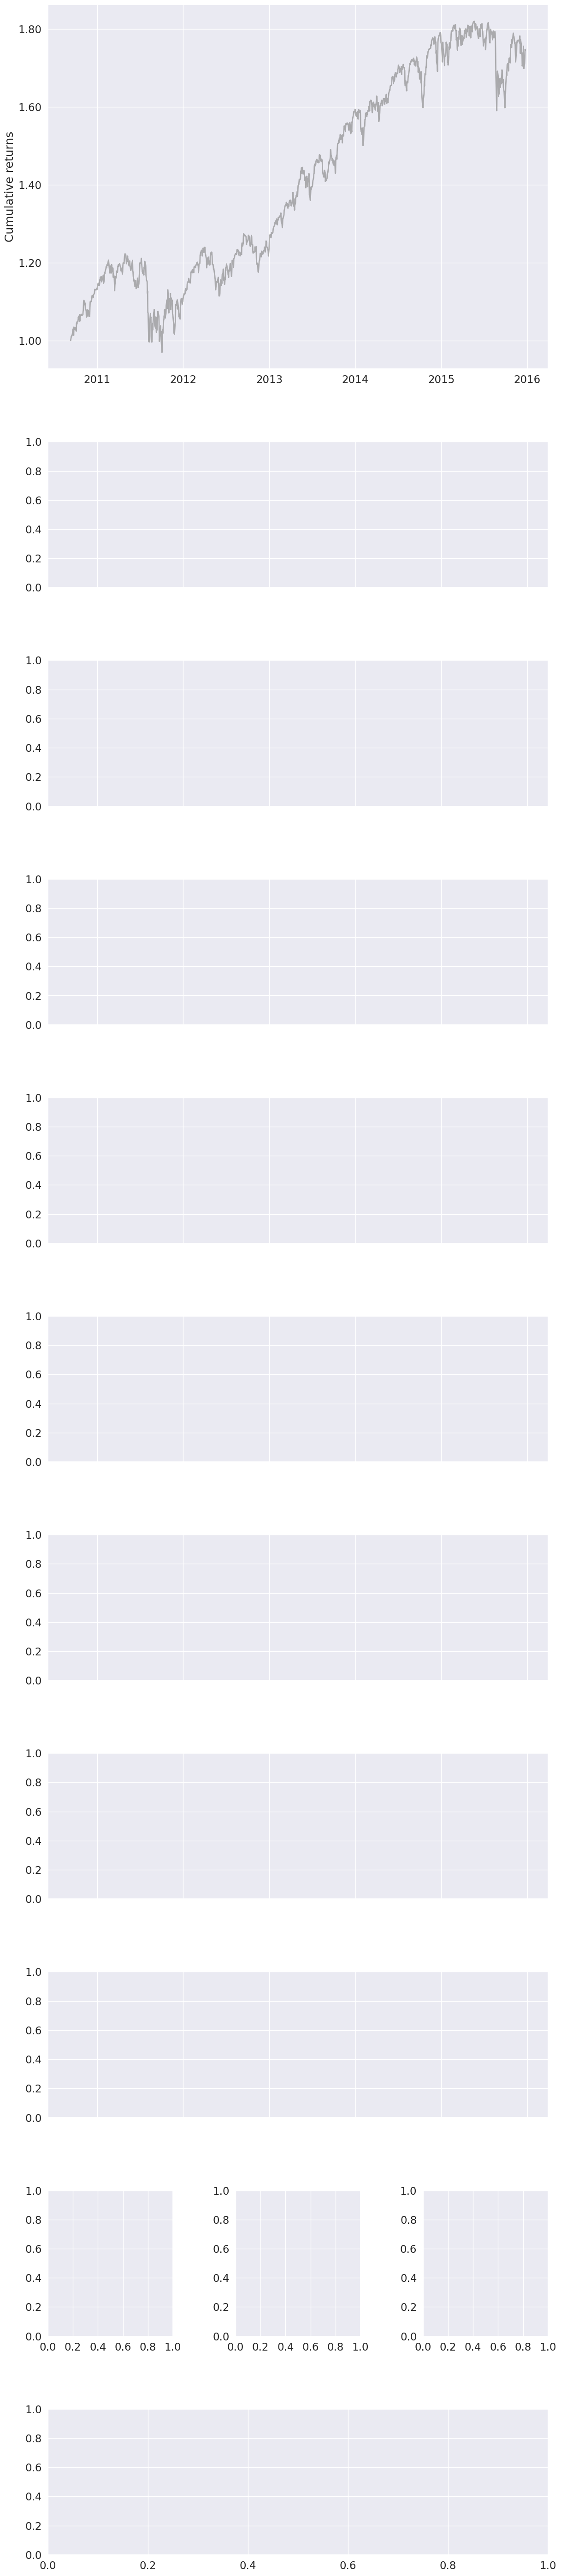

In [23]:
py.create_full_tear_sheet(stock_data['Portfolio_Value_rets'], benchmark_rets = benchmark_data['benchmark_rets'], live_start_date = live_date)